In [ ]:
# Mục tiêu: nạp toàn bộ ảnh trong dataset (CIFAR-10 hoặc thư mục cục bộ)
# Đầu ra: X (N,H,W,C) RGB uint8, y (N,), classes (list tên lớp)

def load_images_from_folder(root_dir, max_per_class=None):
    """
    Nạp ảnh từ thư mục cục bộ có cấu trúc:
      root_dir/
        ├── class_1/ img_*.jpg|png|...
        ├── class_2/ ...
    Trả về:
        X (N,H,W,C) RGB uint8
        y (N,)
        classes (list tên lớp)
    """
    X_list, y_list = [], []
    classes = [d for d in sorted(os.listdir(root_dir)) if os.path.isdir(os.path.join(root_dir, d))]
    for ci, cls in enumerate(classes):
        cls_dir = os.path.join(root_dir, cls)
        count = 0
        for fn in os.listdir(cls_dir):
            if fn.lower().endswith((".png", ".jpg", ".jpeg", ".bmp")):
                fpath = os.path.join(cls_dir, fn)
                img = cv2.imread(fpath)  # BGR uint8
                if img is None:
                    continue
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # BGR → RGB
                X_list.append(img)
                y_list.append(ci)
                count += 1
                # Nếu có max_per_class, dừng lại
                if max_per_class is not None and count >= max_per_class:
                    break
    X = np.array(X_list, dtype=np.uint8)
    y = np.array(y_list, dtype=np.int32)
    return X, y, classes


# ---- Chọn chế độ tải dữ liệu ----
USE_TORCHVISION = TORCH_OK  # True = dùng CIFAR-10; False = dùng ảnh cục bộ

if USE_TORCHVISION:
    # --- Phương án A: dùng toàn bộ CIFAR-10 ---
    data_root = "./data/images/cifar10"
    os.makedirs(data_root, exist_ok=True)

    base_transform = transforms.Compose([
        transforms.ToTensor()   # [0,1] Tensor, shape (C,H,W)
    ])

    # Tải cả tập train + test
    train_set = datasets.CIFAR10(root=data_root, train=True,  download=True, transform=base_transform)
    test_set  = datasets.CIFAR10(root=data_root, train=False, download=True, transform=base_transform)

    # Gộp 2 tập lại để xử lý toàn bộ ảnh
    all_set = train_set + test_set
    N_TOTAL = len(all_set)
    print(f"Tổng số ảnh CIFAR-10 (train+test): {N_TOTAL}")

    # Lấy toàn bộ ảnh (không giới hạn)
    X_list, y_list = [], []
    for i in range(N_TOTAL):
        img_t, label = all_set[i]  # Tensor (C,H,W) [0,1]
        img_np = (img_t.permute(1,2,0).numpy() * 255).astype(np.uint8)  # → (H,W,C) RGB uint8
        X_list.append(img_np)
        y_list.append(label)

    X = np.stack(X_list, axis=0)
    y = np.array(y_list, dtype=np.int32)
    classes = train_set.classes

else:
    # --- Phương án B: dùng thư mục cục bộ ---
    local_dir = "./data/images/cifar10_local"  # thay đường dẫn thật nếu khác
    X, y, classes = load_images_from_folder(local_dir, max_per_class=None)
    print(f"Tổng số ảnh đọc được: {len(X)} từ {len(classes)} lớp.")

print("X shape:", X.shape, "| dtype:", X.dtype, "| y shape:", y.shape)
print("Số lớp:", len(classes), "| Ví dụ lớp:", classes[:5])

In [ ]:
# Mục tiêu: nạp toàn bộ ảnh của tập dữ liệu (không cắt mẫu) → đảm bảo mọi bước sau (resize, grayscale, normalization) đều áp dụng trên toàn tập.
# Hai chế độ linh hoạt:
# CIFAR-10 (torchvision) – dùng trực tiếp, có 60 000 ảnh (50 000 train + 10 000 test).
# Thư mục cục bộ – nạp mọi ảnh trong cây thư mục theo tên lớp.
# Định dạng đầu ra:
# X: mảng ảnh RGB uint8 kích thước (N, H, W, C) để OpenCV thao tác dễ dàng.
# y: nhãn số nguyên ứng với mỗi ảnh.
# classes: danh sách tên lớp.
# Lý do giữ toàn bộ tập: để đảm bảo phân tích thống kê (mean, std, Var(Laplacian), histogram, v.v.) phản ánh toàn bộ dữ liệu, không bị sai lệch mẫu.

In [2]:
# Mục tiêu: tạo X (N,H,W,C RGB uint8) & y (nhãn) sẵn sàng cho các bước tiếp theo.

def load_images_from_folder(root_dir, max_per_class=100):
    """
    Nạp ảnh cục bộ theo cấu trúc:
      root_dir/
        ├── class_1/ img_*.jpg|png|...
        ├── class_2/ ...
    Trả về: X (N,H,W,C RGB uint8), y (N,), classes (list tên lớp)
    """
    X_list, y_list = [], []
    classes = [d for d in sorted(os.listdir(root_dir)) if os.path.isdir(os.path.join(root_dir, d))]
    for ci, cls in enumerate(classes):
        cls_dir = os.path.join(root_dir, cls)
        count = 0
        for fn in os.listdir(cls_dir):
            if fn.lower().endswith((".png", ".jpg", ".jpeg", ".bmp")):
                fpath = os.path.join(cls_dir, fn)
                img = cv2.imread(fpath)                 # BGR uint8
                if img is None:
                    continue
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # BGR -> RGB
                X_list.append(img); y_list.append(ci)
                count += 1
                if count >= max_per_class:
                    break
    X = np.array(X_list, dtype=np.uint8)
    y = np.array(y_list, dtype=np.int32)
    return X, y, classes

# ---- Chọn 1 trong 2 cách nạp ----
USE_TORCHVISION = TORCH_OK  # thay False nếu muốn buộc dùng ảnh cục bộ

if USE_TORCHVISION:
    data_root = "./data/images/cifar10"
    os.makedirs(data_root, exist_ok=True)
    base_transform = transforms.Compose([transforms.ToTensor()])  # chỉ ToTensor để giữ nguyên hình gốc
    train_set = datasets.CIFAR10(root=data_root, train=True,  download=True, transform=base_transform)
    test_set  = datasets.CIFAR10(root=data_root, train=False, download=True, transform=base_transform)

    N_SAMPLE = 500  # số ảnh demo; tăng nếu máy mạnh
    idxs = np.random.choice(len(train_set), size=N_SAMPLE, replace=False)

    X_list, y_list = [], []
    for i in idxs:
        img_t, label = train_set[i]                      # img_t: Tensor (C,H,W) [0,1]
        img_np = (img_t.permute(1,2,0).numpy()*255).astype(np.uint8)  # -> (H,W,C) RGB uint8
        X_list.append(img_np); y_list.append(label)
    X = np.stack(X_list, axis=0)
    y = np.array(y_list, dtype=np.int32)
    classes = train_set.classes
else:
    # Đổi đường dẫn dưới đây tới thư mục dữ liệu thật sự nếu dùng ảnh cục bộ
    local_dir = "./data/images/cifar10_local"
    X, y, classes = load_images_from_folder(local_dir, max_per_class=100)

print("X shape:", X.shape, "| dtype:", X.dtype, "| y shape:", y.shape)
print("Số lớp:", len(classes), "| Ví dụ lớp:", classes[:5])

100%|████████████████████████████████████████████████████████████████████████████████| 170M/170M [13:12<00:00, 215kB/s]


X shape: (500, 32, 32, 3) | dtype: uint8 | y shape: (500,)
Số lớp: 10 | Ví dụ lớp: ['airplane', 'automobile', 'bird', 'cat', 'deer']


In [ ]:
# Tạo X ở dạng RGB uint8 (N,H,W,C) để thao tác thuận tiện với OpenCV/PIL.
# Dữ liệu màu cần thiết cho phần chuyển xám và so sánh thông tin màu.
# Lấy mẫu N=500 để thao tác nhanh; có thể tăng khi cần trực quan nhiều hơn.

In [3]:
# Mục tiêu: đồng nhất kích thước ảnh, so sánh chi phí bộ nhớ để nói về trade-off.

def resize_batch(images, target_hw, interp=cv2.INTER_LINEAR):
    """
    images: (N,H,W,C) RGB uint8
    target_hw: (H_new, W_new)
    interp: phương pháp nội suy (mặc định bilinear)
    """
    Hn, Wn = target_hw
    out = []
    for img in images:
        resized = cv2.resize(img, (Wn, Hn), interpolation=interp)  # resize nhận (W,H)
        out.append(resized)
    return np.stack(out, axis=0)

X_128 = resize_batch(X, (128,128))   # Resize nhẹ
X_224 = resize_batch(X, (224,224))   # Chuẩn nhiều backbone CNN

def approx_memory_mb(arr):           # Ước lượng bộ nhớ (MB)
    return arr.nbytes / (1024**2)

mem_info = pd.DataFrame({
    "Kích thước": ["gốc", "128x128", "224x224"],
    "Shape":      [str(X.shape), str(X_128.shape), str(X_224.shape)],
    "Bộ nhớ ~MB": [approx_memory_mb(X), approx_memory_mb(X_128), approx_memory_mb(X_224)]
})
mem_info

,Kích thước,Shape,Bộ nhớ ~MB
0,gốc,"(500, 32, 32, 3)",1.464844
1,128x128,"(500, 128, 128, 3)",23.437500
2,224x224,"(500, 224, 224, 3)",71.777344


In [ ]:
# Dùng nội suy bilinear (INTER_LINEAR): cân bằng tốt giữa tốc độ & chất lượng cho ảnh tự nhiên.
# So sánh 128×128 (nhẹ, nhanh) với 224×224 (chuẩn ResNet/MobileNet/EfficientNet-B0).
# Trade-off: kích thước ↑ ⇒ RAM/FLops↑, chi tiết không gian ↑ ⇒ tiềm năng chính xác ↑ (nếu mô hình đủ năng lực).

In [4]:
# Mục tiêu: chuyển xám theo luminance và so sánh mức độ chi tiết bằng Var(Laplacian).

def rgb_to_gray_batch(images):
    """
    images: (N,H,W,C) RGB uint8
    return: (N,H,W) gray uint8 (theo cv2.COLOR_BGR2GRAY)
    """
    images_bgr = images[..., ::-1]  # RGB -> BGR (OpenCV dùng BGR)
    gray_list = [cv2.cvtColor(im, cv2.COLOR_BGR2GRAY) for im in images_bgr]
    return np.stack(gray_list, axis=0)

def var_laplacian_batch(grays):
    """
    grays: (N,H,W) uint8
    return: (N,) variance of Laplacian (proxy sắc nét/biên)
    """
    vals = []
    for g in grays:
        v = cv2.Laplacian(g, cv2.CV_64F).var()  # Laplacian + phương sai
        vals.append(v)
    return np.array(vals)

G_224 = rgb_to_gray_batch(X_224)                           # Ảnh xám từ 224x224
sharp_on_rgb = var_laplacian_batch(rgb_to_gray_batch(X_224))  # đo sắc nét proxy cho RGB (đổi sang xám rồi đo)
sharp_on_gray = var_laplacian_batch(G_224)

summary_gray = pd.DataFrame({
    "Var(Lap) proxy (RGB)": sharp_on_rgb,
    "Var(Lap) (Gray)":      sharp_on_gray
})
summary_gray.describe()

,Var(Lap) proxy (RGB),Var(Lap) (Gray)
count,500.000000,500.000000
mean,6.283956,6.283956
std,2.855676,2.855676
min,1.463927,1.463927
25%,4.363630,4.363630
50%,5.610521,5.610521
75%,7.381936,7.381936
max,20.887217,20.887217


In [ ]:
# Luminance (BT.601): 𝑌 = 0.299𝑅 + 0.587𝐺 + 0.114𝐵
# Var(Laplacian) Var((delta)^2)𝐼) là proxy phổ biến cho mức độ chi tiết/biên (cao → nhiều cạnh).
# Kết quả thường cho thấy chuyển xám giữ cấu trúc biên khá tốt nhưng mất thông tin màu 
# → Nên xám: khi nhiệm vụ dựa hình dạng/biên (chữ viết tay, X-ray, tài liệu).
# → Tránh xám: khi màu là đặc trưng phân lớp quan trọng (trái cây chín, biển báo theo màu, bệnh lá).

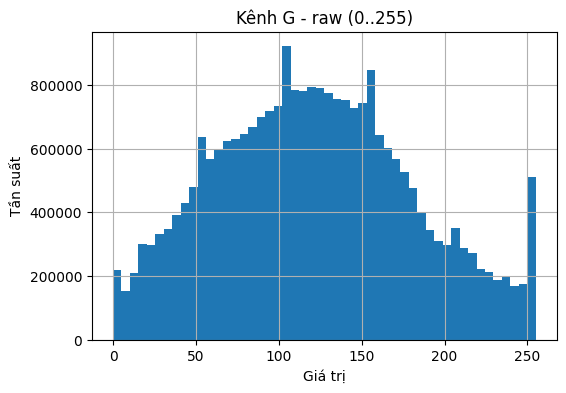

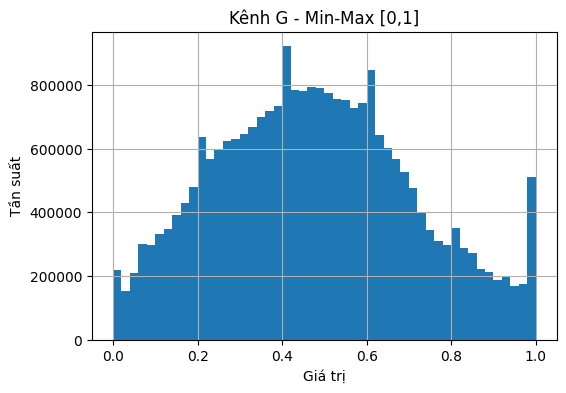

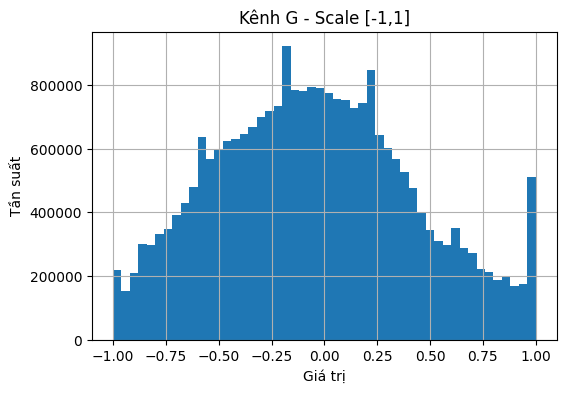

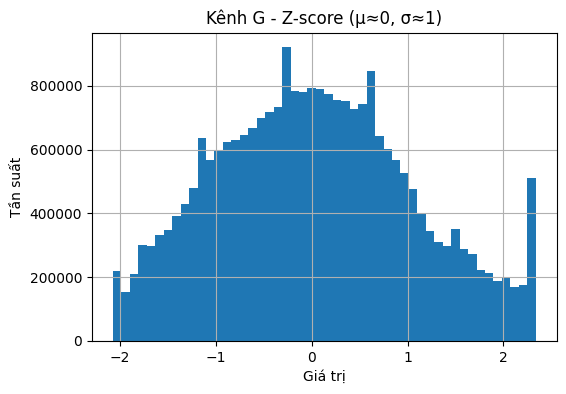

In [6]:
# Mục tiêu: triển khai các kiểu chuẩn hoá phổ biến cho ảnh.

Xf = X_224.astype(np.float32)      # Ép float32 để tính toán ổn định

# 4.1 Min-Max về [0,1] cho ảnh 8-bit (0..255)
X_01 = Xf / 255.0                  # Nhanh & chuẩn

# 4.2 Tuyến tính về [-1,1] từ [0,1]
X_m11 = X_01 * 2.0 - 1.0

# 4.3 Z-score (chuẩn hoá-tiêu chuẩn) theo kênh R,G,B trên toàn bộ tập
means = X_01.reshape(-1, 3).mean(axis=0)   # (3,)
stds  = X_01.reshape(-1, 3).std(axis=0)    # (3,)
X_std = (X_01 - means) / (stds + 1e-8)     # +1e-8 để tránh chia 0

pd.DataFrame({
    "Kênh": ["R","G","B"],
    "Mean [0,1]": means,
    "Std  [0,1]": stds
})

# Mục tiêu: vẽ histogram để thấy phân phối thay đổi trước/sau chuẩn hoá.

def plot_hist(flat_vals, title):
    plt.figure()
    plt.hist(flat_vals, bins=50)
    plt.title(title); plt.xlabel("Giá trị"); plt.ylabel("Tần suất")
    plt.show()

# Minh hoạ trên kênh G
g_raw = Xf[...,1].ravel()    # 0..255
g_01  = X_01[...,1].ravel()  # [0,1]
g_m11 = X_m11[...,1].ravel() # [-1,1]
g_std = X_std[...,1].ravel() # Z-score

plot_hist(g_raw, "Kênh G - raw (0..255)")
plot_hist(g_01,  "Kênh G - Min-Max [0,1]")
plot_hist(g_m11, "Kênh G - Scale [-1,1]")
plot_hist(g_std, "Kênh G - Z-score (μ≈0, σ≈1)")

In [ ]:
# [0,1]: Nhanh, phổ biến; phù hợp hiển thị & một số chỉ số ảnh (PSNR/SSIM).
# [-1,1]: Hữu ích khi lớp kích hoạt/mạng mong dữ liệu đối xứng quanh 0 (ví dụ có tanh).
# Z-score: theo kênh (R,G,B) giúp dữ liệu có thang đo đồng nhất → tối ưu ổn định, thường hội tụ nhanh hơn cho SGD/Adam và cũng hữu ích với ML cổ điển (KNN/SVM).

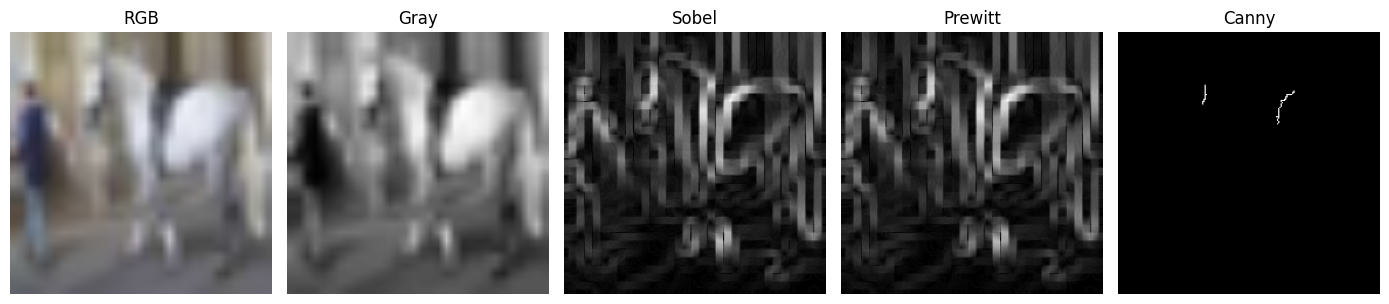

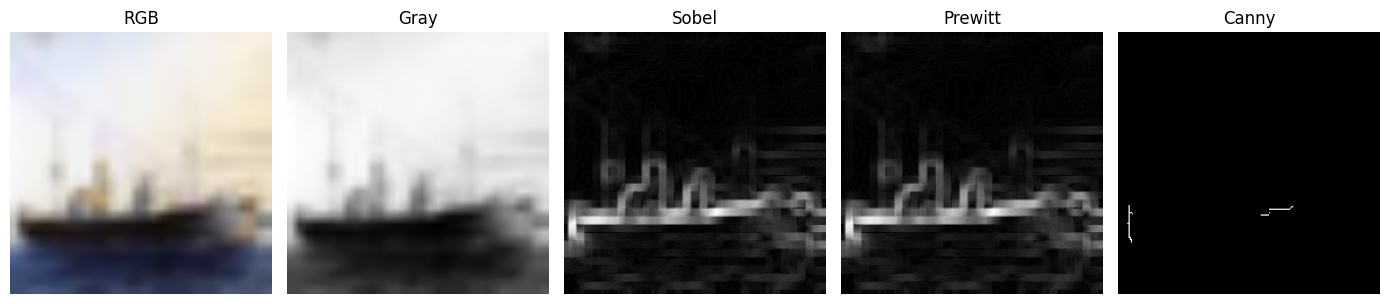

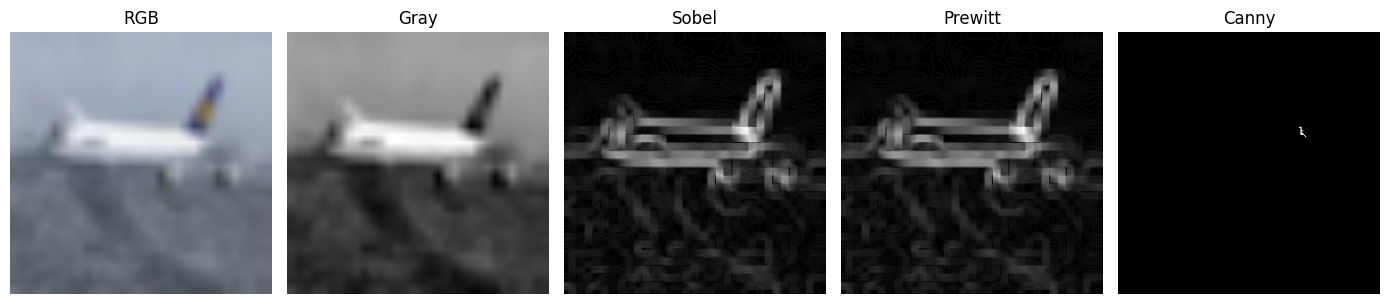

In [7]:
# Mục tiêu: tạo đặc trưng biên để nhấn mạnh hình dạng/đường viền.

def sobel_edges(gray):
    """
    gray: (H,W) uint8
    return: (H,W) uint8 bản đồ biên theo độ lớn gradient
    """
    gx = cv2.Sobel(gray, cv2.CV_32F, 1, 0, ksize=3)  # đạo hàm theo x
    gy = cv2.Sobel(gray, cv2.CV_32F, 0, 1, ksize=3)  # đạo hàm theo y
    mag = np.sqrt(gx**2 + gy**2)                     # M = sqrt(gx^2 + gy^2)
    mag = (255 * (mag / (mag.max() + 1e-8))).astype(np.uint8)  # scale 0..255
    return mag

def prewitt_edges(gray):
    """
    Triển khai Prewitt bằng filter2D với kernel tiêu chuẩn.
    """
    kx = np.array([[-1, 0, 1],
                   [-1, 0, 1],
                   [-1, 0, 1]], dtype=np.float32)
    ky = np.array([[ 1,  1,  1],
                   [ 0,  0,  0],
                   [-1, -1, -1]], dtype=np.float32)
    gx = cv2.filter2D(gray, cv2.CV_32F, kx)
    gy = cv2.filter2D(gray, cv2.CV_32F, ky)
    mag = np.sqrt(gx**2 + gy**2)
    mag = (255 * (mag / (mag.max() + 1e-8))).astype(np.uint8)
    return mag

def canny_edges(gray, lo=80, hi=160):
    """
    Canny: Gaussian blur -> gradient -> NMS -> threshold kép -> hysteresis.
    Chọn lo≈0.4*hi, tinh chỉnh theo dữ liệu thực tế.
    """
    return cv2.Canny(gray, threshold1=lo, threshold2=hi)

# Hiển thị so sánh trên vài ảnh
idx_demo = [0, 1, 2]
for i in idx_demo:
    rgb = X_224[i]
    g   = G_224[i]
    e1 = sobel_edges(g)
    e2 = prewitt_edges(g)
    e3 = canny_edges(g, lo=80, hi=160)

    fig, axes = plt.subplots(1,5, figsize=(14,3))
    axes[0].imshow(rgb); axes[0].set_title("RGB"); axes[0].axis('off')
    axes[1].imshow(g, cmap='gray'); axes[1].set_title("Gray"); axes[1].axis('off')
    axes[2].imshow(e1, cmap='gray'); axes[2].set_title("Sobel"); axes[2].axis('off')
    axes[3].imshow(e2, cmap='gray'); axes[3].set_title("Prewitt"); axes[3].axis('off')
    axes[4].imshow(e3, cmap='gray'); axes[4].set_title("Canny"); axes[4].axis('off')
    plt.tight_layout(); plt.show()

In [ ]:
# Sobel/Prewitt: tích chập kernel đạo hàm bậc 1 → bản đồ biên nhanh & trực quan.
# Canny: mạnh hơn nhờ non-maximum suppression và hysteresis → biên mảnh, sạch nhiễu.
# Dùng biên như một kênh phụ (feature engineering) khi bài toán nhấn mạnh hình dạng.

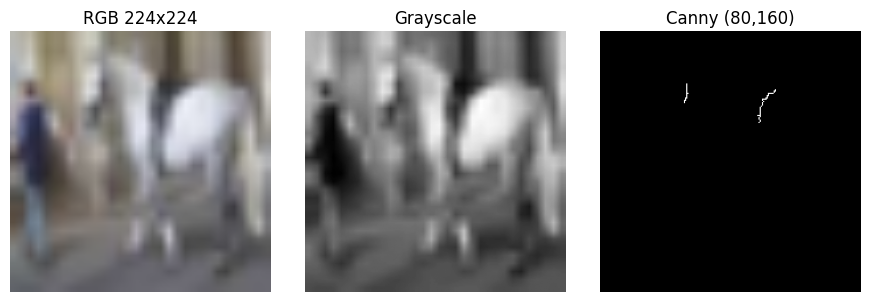

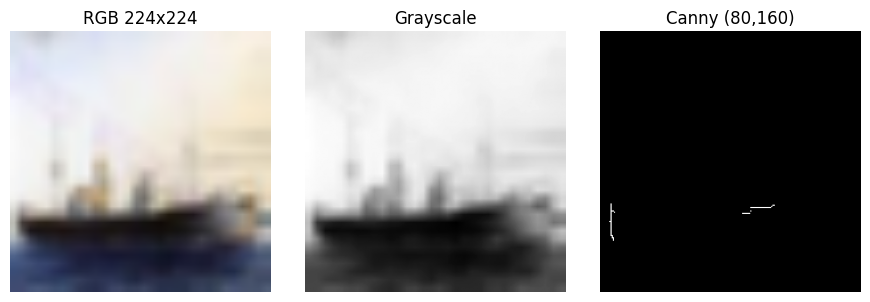

In [8]:
# Mục tiêu: hiển thị nhanh một ảnh RGB, bản xám và biên Canny để minh họa.

def show_grid(i, lo=80, hi=160):
    rgb  = X_224[i]
    gray = G_224[i]
    edge = canny_edges(gray, lo, hi)

    fig, axes = plt.subplots(1,3, figsize=(9,3))
    axes[0].imshow(rgb);  axes[0].set_title("RGB 224x224"); axes[0].axis('off')
    axes[1].imshow(gray, cmap='gray'); axes[1].set_title("Grayscale");  axes[1].axis('off')
    axes[2].imshow(edge, cmap='gray'); axes[2].set_title(f"Canny ({lo},{hi})"); axes[2].axis('off')
    plt.tight_layout(); plt.show()

# Ví dụ gọi:
show_grid(0)
show_grid(1)

In [ ]:
# Lưới ảnh giúp trình bày trực quan: ảnh gốc → xám → biên.